In [1]:
#@title Importting some library
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score


In [2]:
#@title Get the dataset and save it in df
#URL : https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data

path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")
df = pd.read_csv(path + '/AI_Human.csv')

100%|██████████| 350M/350M [00:03<00:00, 113MB/s]

Extracting files...


In [3]:
#Generated by AI (1) or Human (0)
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


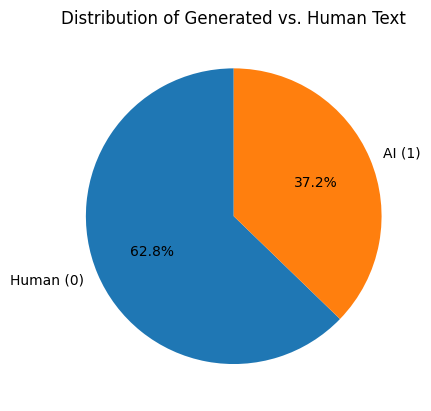

In [6]:
#@title Distribution of Generated vs. Human Text
labels = ['Human (0)', 'AI (1)']
df.generated.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=labels)
plt.title('Distribution of Generated vs. Human Text')
plt.ylabel('')
plt.show()

In [10]:
#@title Reducing the dataset

ai_count = df[df['generated'] == 1.0].shape[0]
human_df_sampled = df[df['generated'] == 0.0].sample(n=ai_count, random_state=42)
df = pd.concat([human_df_sampled, df[df['generated'] == 1.0]])


df.generated.value_counts()

,count
generated,
0.0,181438
1.0,181438


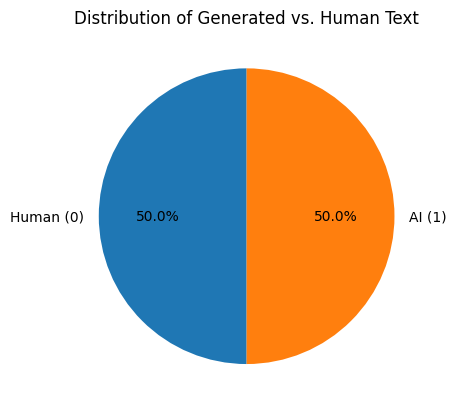

In [9]:
#@title Distribution of Generated vs. Human Text

labels = ['Human (0)', 'AI (1)']
df.generated.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=labels)
plt.title('Distribution of Generated vs. Human Text')
plt.ylabel('')
plt.show()

In [40]:
#@title Remove stopword and emojis

!pip install emoji
import re
import nltk
from nltk.corpus import stopwords
import emoji

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Removes emojis and stopwords from text."""
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df['text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#@title Rechange type of data
df['generated'] = df['generated'].apply(lambda x:{0.0 : 0 , 1.0:1}.get(x,x))

In [15]:
df.head(1)

,text,generated
315265,electoral college unfair voters. Electing pres...,0


In [ ]:
#https://github.com/00hussein00/Social-Media-Comment-Sentiment-Analysis-QD-/blob/main/Social%20Media%20Sentiment%20Analysis.ipynb

In [16]:
#@title Create victraization layer


import tensorflow as tf

# Define the vocabulary size and maximum sequence length
vocab_size = 10000
max_len = 128

# Create the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=max_len)

# Adapt the layer to the text data
vectorize_layer.adapt(df['text'])

In [20]:
#@title Train and split the df

from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df['text']
y = df['generated']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 290300
Testing set size: 72576


In [22]:
#@title Result
res = {}

In [21]:
#@title random forst

from sklearn.ensemble import RandomForestClassifier

# Vectorize the training and testing text data
X_train = vectorize_layer(X_train)
X_test = vectorize_layer(X_test)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
res['Random Forest'] = accuracy
print(f"Random Forest Model Accuracy: {accuracy}")

Random Forest Model Accuracy: 0.876984126984127


In [27]:
#@title Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Vectorize the training and testing text data again for Logistic Regression
X_train_lr = vectorize_layer(X_train)
X_test_lr = vectorize_layer(X_test)

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train_lr, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_lr)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
res['Logistic Regression'] = accuracy_lr
print(f"Logistic Regression Model Accuracy: {accuracy_lr}")

Logistic Regression Model Accuracy: 0.6010389109347443


In [29]:
#@title XGBoost

import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np

# Vectorize the training and testing text data
X_train_xgb = vectorize_layer(X_train)
X_test_xgb = vectorize_layer(X_test)

# Convert the vectorized data to NumPy arrays of integers
X_train_xgb = np.array(X_train_xgb, dtype=np.int64)
X_test_xgb = np.array(X_test_xgb, dtype=np.int64)

# Initialize and train the XGBoost model
# You might want to tune hyperparameters
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_xgb, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
res['XGBoost'] = accuracy_xgb
print(f"XGBoost Model Accuracy: {accuracy_xgb}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:46:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Accuracy: 0.8668843694885362


In [31]:
#@title RNN with LSTM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Apply the vectorization layer to the training and testing data
X_train_vec_rnn = vectorize_layer(X_train)
X_test_vec_rnn = vectorize_layer(X_test)

# Define the model
model = Sequential([
    Input(shape=(max_len,), dtype=tf.int64),
    Embedding(input_dim=vocab_size, output_dim=64, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_vec_rnn, y_train,
                    epochs = 4,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
loss, accuracy_rnn = model.evaluate(X_test_vec_rnn, y_test)
res['RNN with LSTM'] = accuracy_rnn
print(f"RNN with LSTM Model Accuracy: {accuracy_rnn}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 128, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 714,369 (2.73 MB)

 Trainable params: 714,369 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
7258/7258 ━━━━━━━━━━━━━━━━━━━━ 2165s 297ms/step - binary_accuracy: 0.9697 - loss: 0.0769 - val_binary_accuracy: 0.9943 - val_loss: 0.0173
Epoch 2/4
7258/7258 ━━━━━━━━━━━━━━━━━━━━ 2126s 290ms/step - binary_accuracy: 0.9967 - loss: 0.0110 - val_binary_accuracy: 0.9964 - val_loss: 0.0113
Epoch 3/4
7258/7258 ━━━━━━━━━━━━━━━━━━━━ 2208s 302ms/step - binary_accuracy: 0.9983 - loss: 0.0052 - val_binary_accuracy: 0.9966 - val_loss: 0.0109
Epoch 4/4
7258/7258 ━━━━━━━━━━━━━━━━━━━━ 2134s 294ms/step - binary_accuracy: 0.9989 - loss: 0.0032 - val_binary_accuracy: 0.9976 - val_loss: 0.0087
2268/2268 ━━━━━━━━━━━━━━━━━━━━ 139s 61ms/step - binary_accuracy: 0.9974 - loss: 0.0078
RNN with LSTM Model Accuracy: 0.9972580671310425


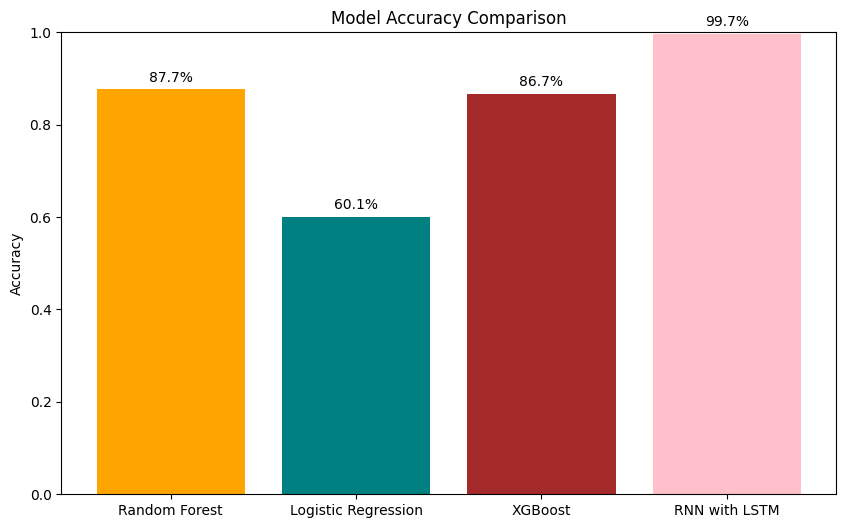

In [44]:
#@title Plotting the results

import matplotlib.pyplot as plt

model_names = list(res.keys())
accuracies = list(res.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['orange', 'teal', 'brown', 'pink'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.1%}', ha='center', va='bottom')

plt.show()

In [32]:
#@title Save the models

import joblib
import tensorflow as tf

# Save Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')

# Save RNN model
model.save('rnn_lstm_model.h5')

print("Models saved successfully.")

Models saved successfully.


In [46]:
def predict_sentiment_rf(text):
    """Predicts sentiment using the Random Forest model."""
    preprocessed_text = clean_text(text)
    vectorized_text = vectorize_layer([preprocessed_text])  # Wrap in list for batch processing
    prediction = rf_model.predict(vectorized_text)
    return prediction[0]


def predict_sentiment_rnn(text):
    """Predicts sentiment using the RNN with LSTM model."""
    preprocessed_text = clean_text(text)
    vectorized_text = vectorize_layer([preprocessed_text])  # Wrap in list for batch processing
    prediction = model.predict(vectorized_text)
    return 1 if prediction[0][0] > 0.5 else 0

## Build the ui



In [47]:
import ipywidgets as widgets
from IPython.display import display

# Create text input area
text_input = widgets.Textarea(
    value='',
    placeholder='Enter text here',
    description='Text:',
    disabled=False,
    layout=widgets.Layout(width='auto', height='100px')
)

# Create predict button
predict_button = widgets.Button(
    description='Predict Sentiment',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict sentiment',
    icon='check' # (FontAwesome icons available)
)

# Create output areas
output_rf = widgets.Output()
output_lr = widgets.Output()

# Display the widgets
display(text_input, predict_button, output_rf, output_lr)

Textarea(value='', description='Text:', layout=Layout(height='100px', width='auto'), placeholder='Enter text h…

Button(description='Predict Sentiment', icon='check', style=ButtonStyle(), tooltip='Click to predict sentiment…

Output()

Output()

**Reasoning**:
Define the function that handles the button click, performs predictions using both models, and updates the output areas, then link the button to this function.



In [48]:
def on_predict_button_clicked(b):
    """Handles button click, predicts sentiment, and updates output areas."""
    text = text_input.value

    with output_rf:
        output_rf.clear_output()
        if text:
            prediction_rf = predict_sentiment_rf(text)
            print(f"Random Forest Prediction: {'Human' if prediction_rf == 0 else 'AI'}")
        else:
            print("Please enter some text.")

    with output_lr:
        output_lr.clear_output()
        if text:
            prediction_rnn = predict_sentiment_rnn(text)
            print(f"RNN Prediction: {'Human' if prediction_rnn == 0 else 'AI'}")


predict_button.on_click(on_predict_button_clicked)

## Display the ui

In [49]:
display(text_input, predict_button, output_rf, output_lr)

Textarea(value='', description='Text:', layout=Layout(height='100px', width='auto'), placeholder='Enter text h…

Button(description='Predict Sentiment', icon='check', style=ButtonStyle(), tooltip='Click to predict sentiment…

Output()

Output()

## Summary and Conclusion

This notebook demonstrates a process for classifying text as either AI-generated or human-written.

1.  **Data Loading and Exploration:** The dataset containing AI and human text was loaded and explored to understand the distribution of the two classes. Initially, there were more human-generated texts, so the dataset was balanced by sampling an equal number of human texts as AI texts.
2.  **Text Preprocessing:** The text data was preprocessed by removing stopwords and emojis to prepare it for model training.
3.  **Text Vectorization:** A `TextVectorization` layer was used to convert the text data into numerical sequences, which is a necessary step for feeding text into most machine learning models.
4.  **Model Training and Evaluation:** Four different models were trained and evaluated on their ability to classify the text:
    *   Random Forest
    *   Logistic Regression
    *   XGBoost
    *   RNN with LSTM
    The accuracy of each model was calculated and visualized.
5.  **Results:** As shown in the "Model Accuracy Comparison" plot, the RNN with LSTM model achieved significantly higher accuracy (99.7%) compared to the other models (Random Forest: 87.7%, Logistic Regression: 60.1%, XGBoost: 86.7%).

**Conclusion:**

Based on the evaluation results, the **RNN with LSTM model is the most effective** among the tested models for this text classification task, achieving near-perfect accuracy on the test set. This suggests that the sequential nature of text is well-captured by the LSTM layers, allowing the model to distinguish between AI-generated and human text with high precision.

While the other models also showed reasonable performance, the RNN with LSTM model's ability to understand context and dependencies in sequences gives it a significant advantage for this type of text classification problem.